In [ ]:
# original: Models/ML/selected_feature_results.ipynb

## Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                              accuracy_score, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline

In [2]:
# import dataset

file_path = '../../datasets/amazon_user_reviews_features_sentiment.parquet'
df = pd.read_parquet(file_path)

df.info()
# based on rsult of feature selection:
## keep one from word_count, char_count, total_punctuatuation, (*verified_purchase)
## keep one from season and month

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18400 entries, 0 to 18399
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiment              18400 non-null  int64  
 1   exclamation_count      18400 non-null  int64  
 2   question_count         18400 non-null  int64  
 3   word_count             18400 non-null  int64  
 4   char_count             18400 non-null  int64  
 5   all_caps_words         18400 non-null  int64  
 6   uppercase_ratio        18400 non-null  float64
 7   total_punctuation      18400 non-null  int64  
 8   avg_word_length        18400 non-null  float64
 9   helpful_vote           18400 non-null  int64  
 10  int_verified_purchase  18400 non-null  int64  
 11  hour                   18400 non-null  int32  
 12  month                  18400 non-null  int32  
 13  season                 18400 non-null  int64  
dtypes: float64(2), int32(2), int64(10)
memory usage: 1.8 M

In [2]:
# import dataset

file_path = '../../datasets/amazon_user_reviews_features_sentiment.parquet'
df = pd.read_parquet(file_path)
# based on rsult of feature selection:
## keep one from word_count, char_count, total_punctuatuation, (*verified_purchase)
## keep one from season and month

# choose word_count, verified_purchase, month
features = ['exclamation_count', 'question_count', 'word_count',
       'all_caps_words', 'uppercase_ratio',
       'avg_word_length', 'helpful_vote', 'int_verified_purchase', 'hour',
       'month']

X = df[features]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [3]:
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # 保留95%的方差
    ('lr', LogisticRegression(C=1.0, max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)

# predict
y_pred      = pipeline.predict(X_test)
y_prob      = pipeline.predict_proba(X_test)

# evaluation
# reference: https://www.geeksforgeeks.org/machine-learning/auc-roc-curve/

print(classification_report(y_test, y_pred))

print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro'):.4f}")

              precision    recall  f1-score   support

           0       0.49      0.32      0.39      1236
           1       0.43      0.42      0.43      1217
           2       0.36      0.50      0.42      1227

    accuracy                           0.41      3680
   macro avg       0.43      0.41      0.41      3680
weighted avg       0.43      0.41      0.41      3680

Accuracy : 0.4125
ROC-AUC  : 0.5936


In [4]:
# cross validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-Validation Accuracy: 0.4108 ± 0.0161


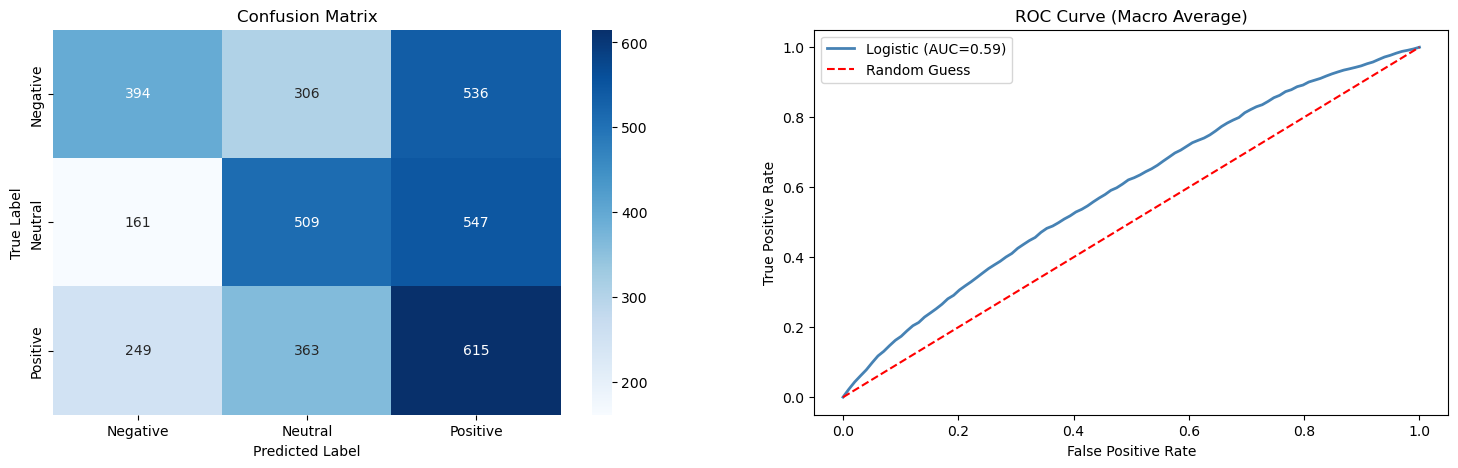

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes     = [0, 1, 2]
class_names = ['Negative', 'Neutral', 'Positive']

# Build test_df from your trained pipelines
test_df = pd.DataFrame({
    'True'        : y_test.values,
    'Logistic'    : list(pipeline.predict_proba(X_test)),
    # 'RandomForest': list(rf_pipeline.predict_proba(X_test))   # add when ready
})

y_pred     = pipeline.predict(X_test)
y_test_bin = label_binarize(test_df['True'], classes=classes)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(test_df['True'], y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

#ROC Curve
model_styles = {'Logistic': 'steelblue'}
# add 'RandomForest': 'darkorange' once have that model

for model, color in model_styles.items():
    y_prob  = np.array(test_df[model].tolist())   # shape: (n_samples, 3)
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([
        np.interp(mean_fpr, *roc_curve(y_test_bin[:, i], y_prob[:, i])[:2])
        for i in range(len(classes))
    ], axis=0)
    macro_auc = auc(mean_fpr, mean_tpr)
    axes[1].plot(mean_fpr, mean_tpr, color=color, lw=2,
                 label=f'{model} (AUC={macro_auc:.2f})')

axes[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')
axes[1].set_title('ROC Curve (Macro Average)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

In [ ]:
#Feature Coefficients
coef       = pipeline.named_steps['lr'].coef_   # shape: (3, n_features)
coef_mean  = coef.mean(axis=0)                  # average across 3 classes
coef_series = pd.Series(coef_mean, index=features).sort_values()
bar_colors  = ['tomato' if c < 0 else 'steelblue' for c in coef_series]

coef_series.plot(kind='barh', color=bar_colors, ax=axes[2])
axes[2].axvline(x=0, color='black', linewidth=0.8, linestyle='--')
axes[2].set_title('Feature Coefficients\n(Mean across classes)')
axes[2].set_xlabel('Coefficient Value')

plt.tight_layout()
plt.savefig('logistic_regression_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

In [13]:
nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])

# train
nb_pipeline.fit(X_train, y_train)

# predict
y_pred = nb_pipeline.predict(X_test)
y_prob = nb_pipeline.predict_proba(X_test)   # shape: (n_samples, 3)

# evaluate
print(classification_report(y_test, y_pred,
      target_names=['Negative', 'Neutral', 'Positive']))

print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro'):.4f}")

# 5-fold cross validation
cv_scores = cross_val_score(nb_pipeline, X, y, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

              precision    recall  f1-score   support

    Negative       0.35      0.91      0.50      1236
     Neutral       0.41      0.09      0.14      1217
    Positive       0.43      0.07      0.12      1227

    accuracy                           0.36      3680
   macro avg       0.40      0.35      0.26      3680
weighted avg       0.40      0.36      0.26      3680

Accuracy : 0.3571
ROC-AUC  : 0.5881
CV Accuracy: 0.3617 ± 0.0064


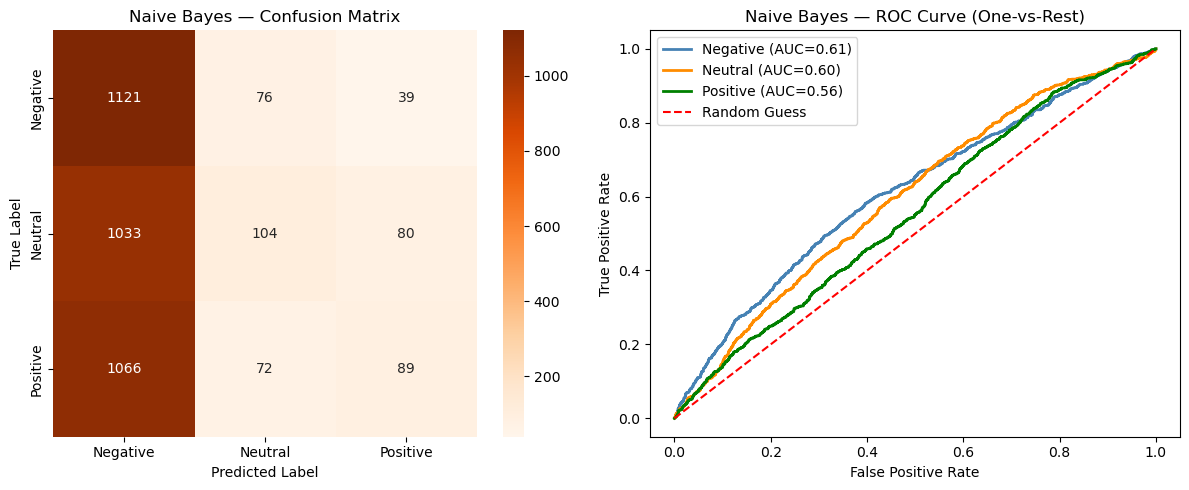

In [14]:
classes     = [0, 1, 2]
class_names = ['Negative', 'Neutral', 'Positive']
y_test_bin  = label_binarize(y_test, classes=classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0]
)
axes[0].set_title('Naive Bayes — Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

colors = ['steelblue', 'darkorange', 'green']
for i, (cls_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'{cls_name} (AUC={roc_auc:.2f})')

axes[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')
axes[1].set_title('Naive Bayes — ROC Curve (One-vs-Rest)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

plt.tight_layout()
plt.savefig('naive_bayes_results.png', dpi=150, bbox_inches='tight')
plt.show()

# SVM

In [8]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [12]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Step 1: scale features
    ('svm',    SVC(
        kernel='linear',   # try 'rbf' for non-linear boundaries
        C=1.0,             # regularisation: lower C = wider margin (more tolerant of misclassification)
                           #                 higher C = narrower margin (fits training data tighter)
        class_weight='balanced',  # handles class imbalance automatically
        probability=True,
        random_state=42
    ))
])

# train SVM model
svm_pipeline.fit(X_train, y_train) 

KeyboardInterrupt: 


Classification Report
              precision    recall  f1-score   support

           0       0.44      0.16      0.24      1236
           1       0.45      0.20      0.28      1217
           2       0.35      0.77      0.48      1227

    accuracy                           0.38      3680
   macro avg       0.41      0.38      0.33      3680
weighted avg       0.41      0.38      0.33      3680



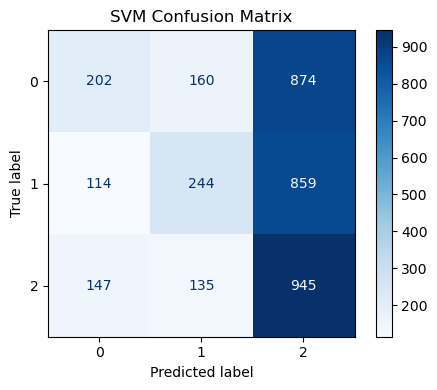

In [ ]:
y_pred = svm_pipeline.predict(X_test)  # EVALUATE on X_test
print("\nClassification Report")
print(classification_report(y_test, y_pred))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
ax.set_title("SVM Confusion Matrix")
plt.tight_layout()
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = [0, 1, 2]
class_names = ['Negative', 'Neutral', 'Positive']

# Get predicted probabilities
y_prob = svm_pipeline.predict_proba(X_test)  # shape: (n_samples, 3)
y_test_bin = label_binarize(y_test, classes=classes)

# Plot ROC curve for each class
fig, ax = plt.subplots(figsize=(6, 5))

colors = ['steelblue', 'darkorange', 'green']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'r--', label='Random Guess')
ax.set_title('SVM ROC Curve (Per Class)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.tight_layout()
plt.show()


The model is heavily biased toward predicting class2.

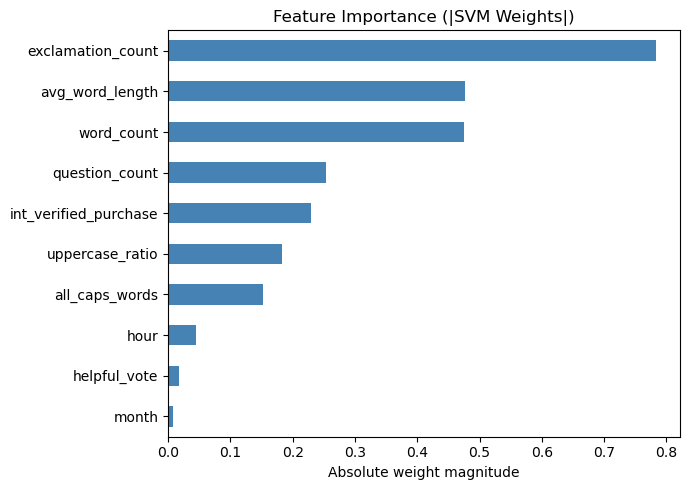

In [8]:
# Feature Importance (linear kernel only)
# For linear SVM, the weight vector w tells you which features matter most.
# Larger |weight| = more influential in the decision boundary.
coefficients = svm_pipeline.named_steps['svm'].coef_[0]
feat_importance = pd.Series(np.abs(coefficients), index=features).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(7, 5))
feat_importance.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title("Feature Importance (|SVM Weights|)")
ax.set_xlabel("Absolute weight magnitude")
plt.tight_layout()
plt.show()

In [9]:
# the class distribution is balanced
print(y.value_counts(normalize=True))

sentiment
0    0.335815
2    0.333424
1    0.330761
Name: proportion, dtype: float64


In [10]:
# Try different kernels
# Linear: good when data is linearly separable (fast, interpretable)
# RBF:    good for non-linear patterns (usually better accuracy, slower)
# Poly:   good for polynomial relationships
kernels = ['linear', 'rbf']
for k in kernels:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=k, C=1.0, class_weight='balanced', random_state=42))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    print(f"Kernel={k:8s} | CV F1 = {scores.mean():.4f} ± {scores.std():.4f}")


Kernel=linear   | CV F1 = 0.3381 ± 0.0046
Kernel=rbf      | CV F1 = 0.4250 ± 0.0086


In [13]:
# C controls the bias-variance tradeoff:
#   Small C → wider margin, allows some misclassification → may underfit
#   Large C → narrower margin, fewer misclassifications → may overfit
print("\nTuning C (linear kernel):")
for C in [0.01, 0.1, 1, 10]:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=C, class_weight='balanced', random_state=42))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    print(f"  C={C:5} | CV F1 = {scores.mean():.4f} ± {scores.std():.4f}")



Tuning C (linear kernel):
  C= 0.01 | CV F1 = 0.3275 ± 0.0076
  C=  0.1 | CV F1 = 0.4072 ± 0.0092
  C=    1 | CV F1 = 0.4250 ± 0.0086
  C=   10 | CV F1 = 0.4209 ± 0.0073


In [14]:
print("Fine-tuning around C=1 with gamma (rbf kernel):")
for C in [0.5, 1.0, 2.0, 5.0]:
    for gamma in ['scale', 'auto', 0.01, 0.1, 1.0]:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf', C=C, gamma=gamma, 
                       class_weight='balanced', random_state=42))
        ])
        scores = cross_val_score(pipe, X_train, y_train, cv=3, 
                                scoring='f1_weighted', n_jobs=-1)
        print(f"  C={C:4} | gamma={str(gamma):5} | CV F1 = {scores.mean():.4f} ± {scores.std():.4f}")

Fine-tuning around C=1 with gamma (rbf kernel):
  C= 0.5 | gamma=scale | CV F1 = 0.4238 ± 0.0077
  C= 0.5 | gamma=auto  | CV F1 = 0.4238 ± 0.0077
  C= 0.5 | gamma=0.01  | CV F1 = 0.3579 ± 0.0100
  C= 0.5 | gamma=0.1   | CV F1 = 0.4238 ± 0.0077
  C= 0.5 | gamma=1.0   | CV F1 = 0.4088 ± 0.0027
  C= 1.0 | gamma=scale | CV F1 = 0.4250 ± 0.0086
  C= 1.0 | gamma=auto  | CV F1 = 0.4250 ± 0.0086
  C= 1.0 | gamma=0.01  | CV F1 = 0.3769 ± 0.0139
  C= 1.0 | gamma=0.1   | CV F1 = 0.4250 ± 0.0086
  C= 1.0 | gamma=1.0   | CV F1 = 0.4065 ± 0.0042
  C= 2.0 | gamma=scale | CV F1 = 0.4231 ± 0.0068
  C= 2.0 | gamma=auto  | CV F1 = 0.4231 ± 0.0068
  C= 2.0 | gamma=0.01  | CV F1 = 0.3925 ± 0.0155
  C= 2.0 | gamma=0.1   | CV F1 = 0.4231 ± 0.0068
  C= 2.0 | gamma=1.0   | CV F1 = 0.4044 ± 0.0040
  C= 5.0 | gamma=scale | CV F1 = 0.4212 ± 0.0059
  C= 5.0 | gamma=auto  | CV F1 = 0.4212 ± 0.0059
  C= 5.0 | gamma=0.01  | CV F1 = 0.4069 ± 0.0138
  C= 5.0 | gamma=0.1   | CV F1 = 0.4212 ± 0.0059
  C= 5.0 | gamma=1.0 

In [10]:
# Final model with best params
best_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', 
                class_weight='balanced', probability = True, random_state=42))
])

# Train on full training set, evaluate on held-out test set
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.36      0.42      1236
           1       0.43      0.45      0.44      1217
           2       0.38      0.49      0.43      1227

    accuracy                           0.43      3680
   macro avg       0.44      0.43      0.43      3680
weighted avg       0.44      0.43      0.43      3680

[[443 352 441]
 [152 547 518]
 [263 364 600]]


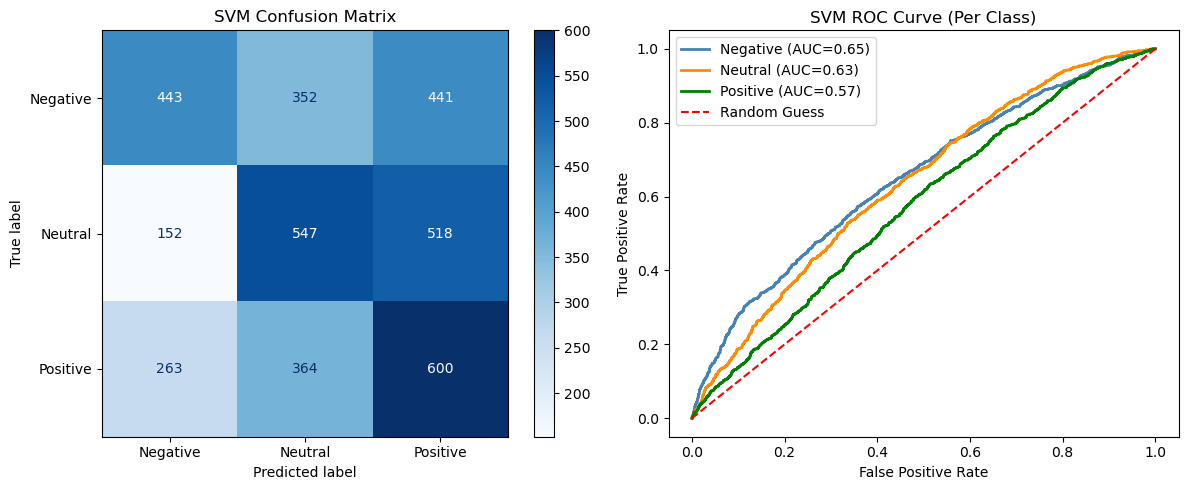

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = [0, 1, 2]
class_names = ['Negative', 'Neutral', 'Positive']

y_prob     = best_pipe.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=class_names,
    cmap='Blues',
    ax=axes[0]
)
axes[0].set_title('SVM Confusion Matrix')

# Plot 2: ROC Curve (Per Class)
colors = ['steelblue', 'darkorange', 'green']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=color, lw=2, label=f'{class_name} (AUC={roc_auc:.2f})')

axes[1].plot([0, 1], [0, 1], 'r--', label='Random Guess')
axes[1].set_title('SVM ROC Curve (Per Class)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

plt.tight_layout()
plt.show()

# Decision Trees
1. Decision Tree

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

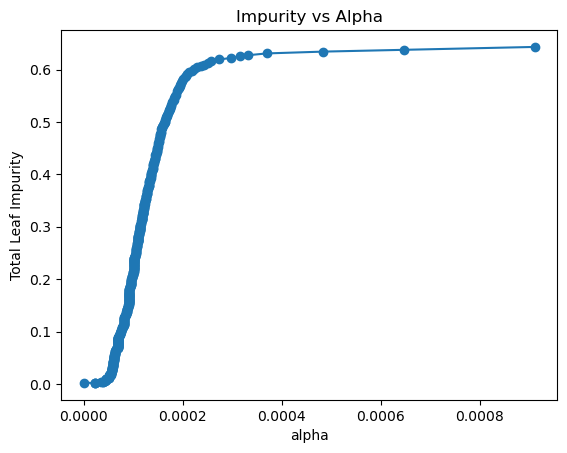

In [16]:
# Decision Tree
X = df[features]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# train the full tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

path = dt.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

# only selecting every 6 other alpha
ccp_alphas = ccp_alphas[::6]
impurities = path.impurities
impurities = impurities[::6]

plt.figure()
plt.plot(ccp_alphas[:-1], impurities[:-1], marker="o")
plt.xlabel("alpha")
plt.ylabel("Total Leaf Impurity")
plt.title("Impurity vs Alpha")
plt.show()

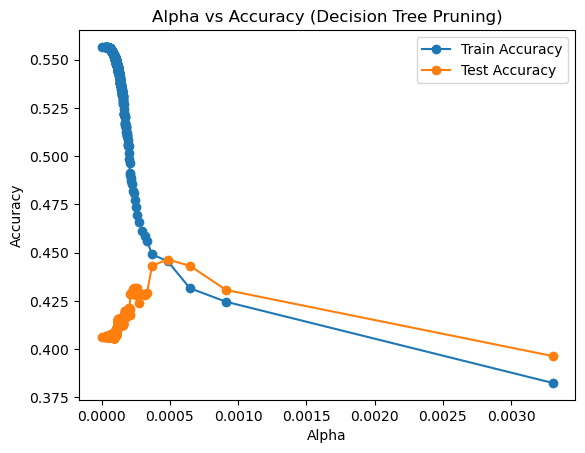

In [18]:
# train a tree using each alpha
clfs = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=42,
        ccp_alpha=alpha,
        max_depth=12,
        min_samples_leaf=5
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)


train_scores = [c.score(X_train, y_train) for c in clfs]
test_scores = [c.score(X_test, y_test) for c in clfs]
plt.figure()

plt.plot(ccp_alphas, train_scores, marker="o", label="Train Accuracy")
plt.plot(ccp_alphas, test_scores, marker="o", label="Test Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy (Decision Tree Pruning)")
plt.legend()
plt.show()


In [19]:
# retrain using the best score alpha
best_alpha = ccp_alphas[np.argmax(test_scores)]
print("Best alpha:", best_alpha)
best_tree = DecisionTreeClassifier(
    random_state=42,
    ccp_alpha=best_alpha
)
best_tree.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_tree.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# The best normal decision tree model have accuracy 0.4462.

Best alpha: 0.0004831774331724159
Test Accuracy: 0.44619565217391305
              precision    recall  f1-score   support

           0       0.48      0.49      0.49      1236
           1       0.42      0.54      0.47      1217
           2       0.45      0.31      0.36      1227

    accuracy                           0.45      3680
   macro avg       0.45      0.45      0.44      3680
weighted avg       0.45      0.45      0.44      3680

[[604 430 202]
 [293 662 262]
 [354 497 376]]


word_count               0.279642
exclamation_count        0.260886
int_verified_purchase    0.123816
helpful_vote             0.121000
all_caps_words           0.096993
uppercase_ratio          0.060806
avg_word_length          0.056858
question_count           0.000000
hour                     0.000000
month                    0.000000
dtype: float64


<Axes: >

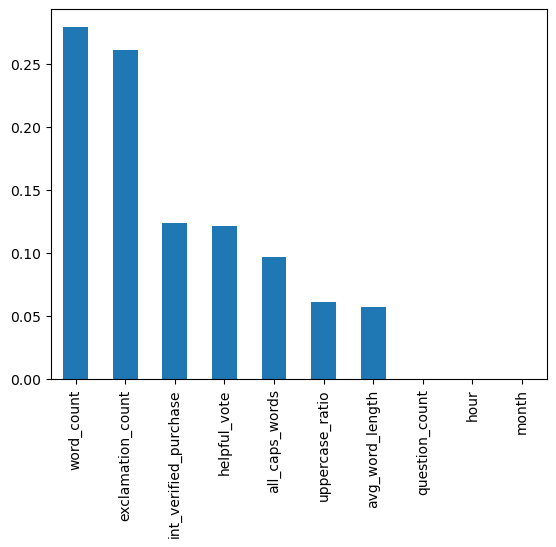

In [20]:
importance = pd.Series(
    best_tree.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(importance)
importance.plot(kind="bar")

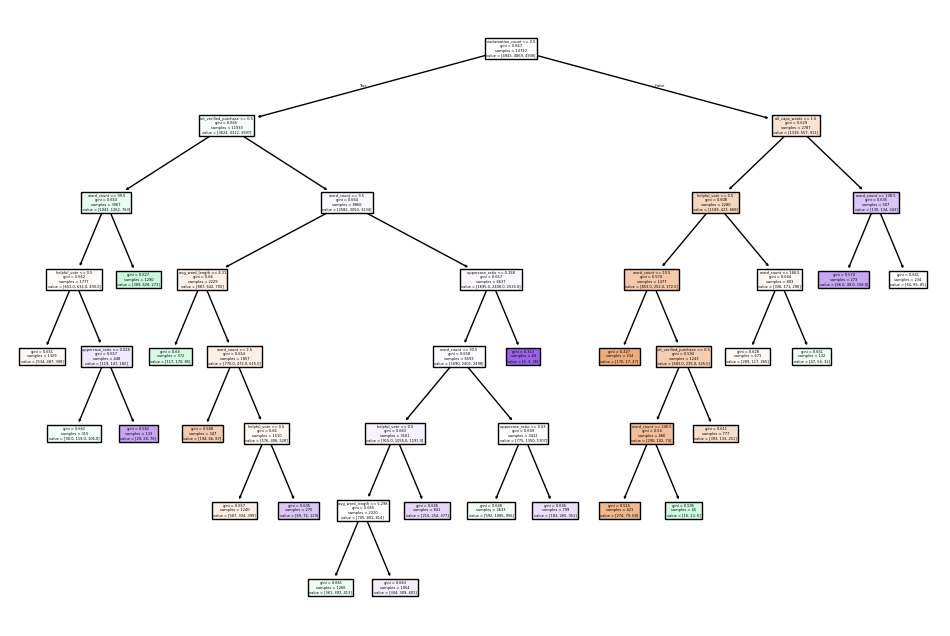

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plot_tree(best_tree, feature_names=X.columns, filled=True)
plt.show()

2. Random Forest

Accuracy: 0.43831521739130436
              precision    recall  f1-score   support

           0       0.48      0.46      0.47      1236
           1       0.42      0.44      0.43      1217
           2       0.42      0.41      0.42      1227

    accuracy                           0.44      3680
   macro avg       0.44      0.44      0.44      3680
weighted avg       0.44      0.44      0.44      3680

avg_word_length          0.201762
uppercase_ratio          0.199497
word_count               0.182279
hour                     0.155271
month                    0.130471
helpful_vote             0.047900
all_caps_words           0.030777
exclamation_count        0.028022
int_verified_purchase    0.012095
question_count           0.011927
dtype: float64


<Axes: >

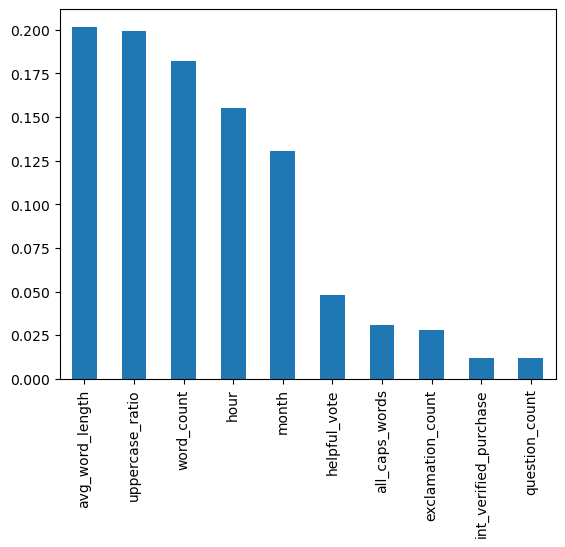

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = df[features]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#train random forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# evaluation
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importance)
importance.plot(kind="bar")